In [1]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from diagnostics.evaluation import rev_weighted_quad_kappa
from diagnostics.evaluation import fit_and_eval, rev_weighted_quad_kappa, rmse, error_rate
from imputers.zero_filler import ZeroFiller
from tools.datasets import get_boston, get_heart, get_houses, get_prudential
from diagnostics.grid_search import custom_grid_search
from config import *
from transformers import BoxCoxTransformer, LabelsClipper, OutliersClipper, CustomOneHotEncoder, CustomBinner, CustomBinaryBinner, FeatureDropper
import warnings
warnings.filterwarnings('ignore')

In [18]:
# cv = KFold(3, shuffle=True, random_state=0)
# scorer = mean_squared_error
# data, labels, continuous, discrete, dummy, categorical, target = get_boston()
# data, labels, continuous, discrete, dummy, categorical, target = get_houses()
# predictors = [LinearRegression()]

# scorer = accuracy_score
# data, labels, continuous, discrete, dummy, categorical, target = get_heart()
# predictors = [LogisticRegression()]
# cv = StratifiedKFold(3, labels)

scorer = rev_weighted_quad_kappa
data, labels, continuous, discrete, dummy, categorical, target = get_prudential()
cv = StratifiedKFold(3)
predictors = [LabelsClipper(regressor=LinearRegression())]

train = data.drop(target, axis=1)

In [3]:
# BINNER_CONFIG = { col: {'values': [train[col].max()]} for col in continuous + discrete }  # houses
# BINNER_CONFIG = { col: {'bins': 3} for col in continuous + discrete }                               # heart
BINNER_CONFIG = { col: {'bins': 5} for col in continuous }                                          # prudential
# BINNER_CONFIG = { col: {'bins': 5} for col in continuous + discrete }                               # boston (or none)

In [4]:
BOX_COX = BOX_COX_P
model = Pipeline([
        ('onehot',       CustomOneHotEncoder(columns=categorical)),
        ('clipper', OutliersClipper(continuous)),
        ('binner', CustomBinaryBinner({})),
        ('binner2', CustomBinaryBinner({})),
        ('zero_filler',  ZeroFiller()),
        ('boxcox', BoxCoxTransformer(BOX_COX)),
        ('scaler', StandardScaler()),
        ('predictor',   None)  
])

In [5]:

params = [
    { # BASELINE
        'clipper': [None],
        'binner': [None],
        'binner2': [None],
        'boxcox': [None],
        'scaler': [None],
        'predictor': predictors
    },
    { # BINNER
        'clipper': [None],
        'binner': [
            CustomBinner(BINNER_CONFIG_PRUD)
        ],
        'binner__nan': [True, False],
        'binner__drop': [True, False],
        'binner2': [None],
        'boxcox': [None],
        'scaler': [None],
        'predictor': predictors
    },
    { # BINNER Binary
        'clipper': [None],
        'binner': [
            CustomBinaryBinner(BINARY_BINNER_CONFIG_PRUD)
        ],
        'binner__nan': [True, False],
        'binner__drop': [True, False],
        'binner2': [None],
        'boxcox': [None],
        'scaler': [None],
        'predictor': predictors
    },
]

In [20]:


start = time()
# grid = GridSearchCV(model, cv=cv, n_jobs=-1, param_grid=params, scoring=make_scorer(scorer))
# grid.fit(train.copy(), labels)

results = custom_grid_search(model, params, data, target, cv, scorer, outliers=None)

end = time()

In [22]:
import numpy
# numpy.set_printoptions(threshold=numpy.nan)
print("GridSearchCV took %.2f seconds for "
      % (end - start, ))
print(results)


GridSearchCV took 180.49 seconds for 
[{'score': 0.4624316341972352, 'std': 0.007798857439361163, 'params': {'binner': None, 'binner2': None, 'boxcox': None, 'clipper': None, 'predictor': LabelsClipper(regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)), 'scaler': None}}, {'score': 0.4535472570163875, 'std': 0.005056952763994587, 'params': {'binner': CustomBinner(configuration={'Medical_History_1': {'values': [0, 240], 'bins': [0, 1, 10, 30, 100, 200, 240]}, 'Medical_History_10': {'values': [0, 240], 'bins': [0, 1, 2, 240]}, 'Medical_History_15': {'values': [0, 240], 'bins': [0, 1, 2, 240]}, 'Medical_History_24': {'values': [0, 240], 'bins': [0, 1, 2, 240]}, 'Medical_History_32': {'values': [0, 240], 'bins': [0, 1, 2, 240]}},
       drop=True, nan=True), 'binner2': None, 'binner__drop': True, 'binner__nan': True, 'boxcox': None, 'clipper': None, 'predictor': LabelsClipper(regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize

In [23]:
# max_std = grid.cv_results_['std_test_score'].max()
# min_score = grid.cv_results_['mean_test_score'].min()
# max_score = grid.cv_results_['mean_test_score'].max()
max_std = max(r['std'] for r in results)
max_score = max(r['score'] for r in results)
min_score = min(r['score'] for r in results)

In [24]:
data = {'baseline': None, 'binner': {}, 'binary binner': {}}
for score, std in zip(grid.grid_scores_,grid.cv_results_['std_test_score'] ):
    if not score.parameters['binner']:
        data['baseline'] = {
            'basic': {
                'mean': score.mean_validation_score,
                'std': std,
            }
        }
    elif isinstance(score.parameters['binner'], CustomBinner):
        labels = []
        if score.parameters['binner__nan']:
            labels.append('nan')
        if score.parameters['binner__drop']:
            labels.append('drop')
        if labels:
            label = ', '.join(labels)
        else:
            label = 'basic'
        data['binner'][label] ={
                'mean': score.mean_validation_score,
                'std': std,
        }
    elif isinstance(score.parameters['binner'], CustomBinaryBinner):
        labels = []
        if score.parameters['binner__nan']:
            labels.append('nan')
        if score.parameters['binner__drop']:
            labels.append('drop')
        if labels:
            label = ', '.join(labels)
        else:
            label = 'basic'
        data['binary binner'][label] = {
                'mean': score.mean_validation_score,
                'std': std,
        }

NameError: name 'grid' is not defined

In [27]:
data = {'baseline': None, 'binner': {}, 'binary binner': {}}
for result in results:
    if not result['params']['binner']:
        data['baseline'] = {
            'basic': {
                'mean': result['score'],
                'std': result['std'],
            }
        }
    elif isinstance(result['params']['binner'], CustomBinner):
        labels = []
        if result['params']['binner__nan']:
            labels.append('nan')
        if result['params']['binner__drop']:
            labels.append('drop')
        if labels:
            label = ', '.join(labels)
        else:
            label = 'basic'
        data['binner'][label] ={
                'mean': result['score'],
                'std': result['std'],
        }
    elif isinstance(result['params']['binner'], CustomBinaryBinner):
        labels = []
        if result['params']['binner__nan']:
            labels.append('nan')
        if result['params']['binner__drop']:
            labels.append('drop')
        if labels:
            label = ', '.join(labels)
        else:
            label = 'basic'
        data['binary binner'][label] = {
                'mean': result['score'],
                'std': result['std'],
        }

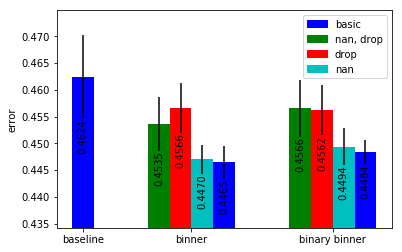

In [28]:
from visualization.plot_results import plot_results
plot_results(data, save_path="./results/fig3.png", precision=4, ymax=1.01*max_score+max_std, ymin=0.99*min_score-max_std)

In [41]:
import json
import pickle
from collections import defaultdict

def plot_and_save_results(results, get_model_and_label, path, precision=4, ymax_alpha=1.01, ymin_alpha=0.99, robust=False):
    max_std = max(r['std'] for r in results)
    max_score = max(r['score'] for r in results)
    min_score = min(r['score'] for r in results)
    output = defaultdict(dict)
    try:
        for result in results:
            model_name, label= get_model_and_label(result['params'])
            output[model_name][label] = {
                'mean': result['score'],
                'std': result['std'],
            }
    except Exception as e:
        if robust:
            with open(path + "_error.p", 'wb') as fp:
                pickle.dump(results, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Error occured', e)
        return 
    
    plot_results(output, save_path=path + ".png", precision=precision, ymax=ymax_alpha*max_score+max_std, ymin=ymin_alpha*min_score-max_std)
    with open(path + '.json', 'w') as fp:
        json.dump(output, fp, indent=4)
    return output


In [44]:
def get_class(params):
    if not params['binner']:
        return 'baseline', 'basic'
    elif isinstance(params['binner'], CustomBinner):
        model_name = 'binner'
    elif isinstance(params['binner'], CustomBinaryBinner):
        model_name = 'binnary binner'
    else:
        model_name = 'other?'
        
    labels = []
    if params['binner__nan']:
        labels.append('nan')
    if params['binner__drop']:
        labels.append('drop')
    if labels:
        label = ', '.join(labels)
    else:
        label = 'basic'
    return model_name, label


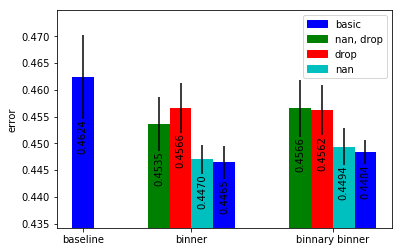

defaultdict(dict,
            {'baseline': {'basic': {'mean': 0.4624316341972352,
               'std': 0.007798857439361163}},
             'binnary binner': {'basic': {'mean': 0.44836532703090826,
               'std': 0.0022873527051151745},
              'drop': {'mean': 0.4562118616563023,
               'std': 0.004737984914723237},
              'nan': {'mean': 0.44936712492613573,
               'std': 0.0034072667614986375},
              'nan, drop': {'mean': 0.4565545920203829,
               'std': 0.005341764288332258}},
             'binner': {'basic': {'mean': 0.4464748286804065,
               'std': 0.0030647365799968},
              'drop': {'mean': 0.4565673455043422,
               'std': 0.004651698134752982},
              'nan': {'mean': 0.44698247430520105,
               'std': 0.0027474780122524966},
              'nan, drop': {'mean': 0.4535472570163875,
               'std': 0.005056952763994587}}})

In [45]:
plot_and_save_results(results, get_class, './results/binning')

In [ ]:
result